# Simple BPSK31 receiver

This notebook shows essential steps to be able to decode [BPSK31](https://en.wikipedia.org/wiki/PSK31) modulation. This popular amateur-radio transmission mode is a variant of [Binary Phase-Shift Keing](https://en.wikipedia.org/wiki/Phase-shift_keying). Input filters and matched filters have been excluded for grater clarity of this demonstration.

In [1]:
import numpy as np
import urllib

from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# download wave file from internet
url = 'http://aintel.bi.ehu.es/Psk31Bpsk.wav'
pskfile = urllib.URLopener()
pskfile.retrieve( url, 'psk.wav' )

# open a wave file
fs, dat_ = wavfile.read( 'psk.wav' )

# convert float and remove the mean
s = dat_.astype( np.float32 ) / 128.0 - 1.0

/usr/local/lib/python2.7/dist-packages/scipy/io/wavfile.py:179: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [3]:
# plot spectrum 
def plotfft( x, fs ):
    k = int( np.floor( x.shape[0] / fs ) )
    x = x[ : k * fs ].reshape( k, fs )
    avg = x.mean( axis=0 ) * signal.blackman( fs )
    f = np.fft.fft( avg )
    plt.plot( range( -fs/2, fs/2 ), 20 * np.log( np.abs( np.fft.fftshift( f ) ) ) )
    plt.axvline( 0, color='r' )


Let's take a look how the original spectrum looks.  The peaks at -1khz and 1khz is the PSK31 carrier

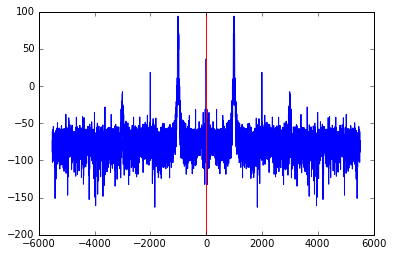

In [4]:
plotfft( s, fs )

We will resample the signal to reduce the number of samples we will have to go through.  8khz was chosen to match original PSK31 implementation

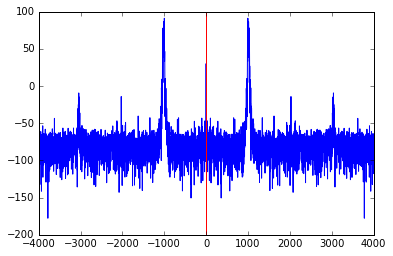

In [5]:
#resample to 8khz
fs8 = 8000
s8 = signal.resample( s, s.shape[0] / fs * fs8 )

plotfft( s8, fs8 )

As a proof of concept we will mix the analytic signal (after Hilbert transformer) to see if it will end in the baseband 

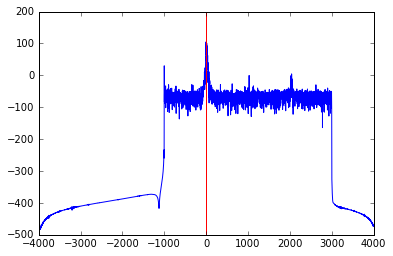

In [6]:
t = np.arange( s8.shape[0] )
car = np.exp( -2j * np.pi * t * 1000 / 8000 )
s8_a = signal.hilbert( s8 )
plotfft( s8_a * car, fs8 )

The above operation shifted the signal spectrum into the right place.  
It's time to use Costas loop to properly find the carrier frequency.  
The other adventage of Costas loop is that it will maitain correct phase of the carrier.

In [7]:
x = s8
x_ = signal.hilbert( x )
y = np.zeros_like( x_ )
vco = np.zeros_like( y )
phase = np.zeros( x.shape )
e1 = np.zeros_like( phase )
e2 = np.zeros_like( phase )
prd = np.zeros_like( phase )

fc = 1000.0

alpha = 0.41
beta = alpha ** 2 / 4.0

for i in np.arange( 0, x.shape[0] - 1 ):
    vco[i] = np.exp( -1j * phase[i] )
    y[i] = x_[i] * vco[i]
    prd[i] = np.real( y[i] ) * np.imag( y[i] )
    e1[i+1] = e1[i] + prd[i] * beta
    e2[i+1] = alpha * prd[i] + e1[i+1]
    phase[i+1] = 2*np.pi * fc / fs + phase[i] + e2[i]

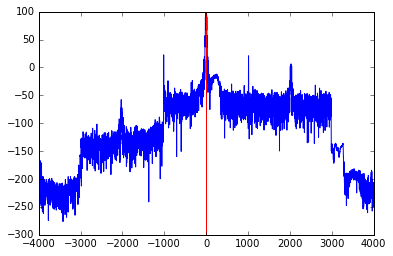

In [8]:
plotfft( y, fs8 )

The carrier has been recovered, let's take a look at the IQ plot.  Visible rotation is caused by the Costas Loop trying to get lock on the 1kHz carrier.  Once the lock is acquired, the samples end up on the real axis.

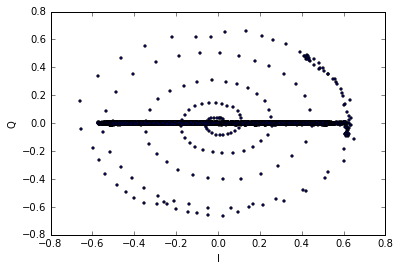

In [11]:
plt.scatter( np.real( y ), np.imag( y ), marker='.' )
plt.xlabel( 'I' )
plt.ylabel( 'Q' )

Signal decimation by 16 to get 16 samples per symbol

In [12]:
y1 = signal.decimate( np.real( y ), 4 )
y2 = signal.decimate( np.real( y1 ), 4 )

Let's try to recover timing of the symbols.  Original specification of BPSK31 shows rate of 31.25 baud.  Here looks like the rate required to get correct symbol timing is 31.56.

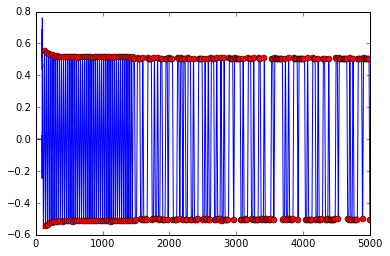

In [13]:
xmin = 0
xmax = 5000

sig = y2

clock = np.arange( 134, len( sig ), 31.56/ 2 )
plt.plot( range( xmin, xmax), sig[ xmin:xmax ] )
c = clock[ ( clock >= xmin ) & ( clock < xmax ) ]
plt.plot( c, sig[c.astype( np.int32 )], 'ro')

Eyediagram to check symbol alignment

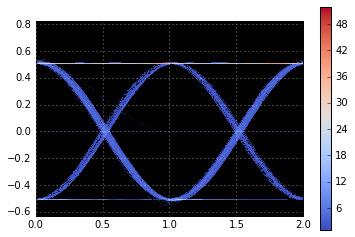

In [15]:
from eyediagram.mpl import eyediagram

num_symbols = clock.shape[0]
offset = 134
samples_per_symbol = 31.56/ 2

eyediagram( sig, 2*samples_per_symbol, offset=offset, cmap=plt.cm.coolwarm)

Function to perform timing recovery.  We will use standard Gardner algorithm.

In [16]:
def timing_recovery( x, T_2=8, ki=0.5, kp=0.3, kd=0.1, initial_offset=134 ):

    ted_int = 0.0
    ted_1 = 0.0
    acc = 0.0

    ACC_ = []
    TED_ = []
    ted_ = []
    symbols = []
    clk_ = []

    # loop over samples
    for i in range( initial_offset, x.shape[0], 2 * T_2 ):
        # adjust the clock
        clk = i + int( acc )
        clk_.append( clk )

        # calculate timing error
        late = x[ clk ]
        prompt = x[ clk - T_2 ]
        early = x[ clk - T_2 * 2 ]
        ted = prompt * ( late - early )
        ted_.append( ted )

        # filter timing error
        ted_int += ted * ki
        ted_err = ted_int + ted * kp + (ted - ted_1) * kd
        ted_1 = ted
        TED_.append( ted_err )

        acc += ted_err
        ACC_.append( acc )

        symbols.append( prompt )

    return symbols, ACC_, TED_, ted_, clk_

In [17]:
symbols, ACC_, TED_, ted_, clk_ = timing_recovery( y2, ki=0.5, kp=1.0, kd=.3, initial_offset=134 )

If the timing recovery loop worked fine, then there should be constant difference between manualy recovered symbol clock and through the Gardner algorithm

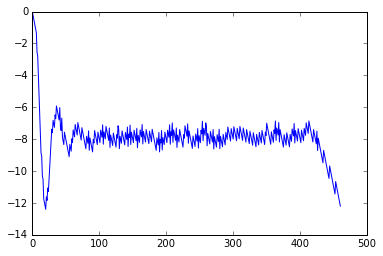

In [18]:
plt.plot( clock[ : len( clk_ ) ] - np.array( clk_ ) )

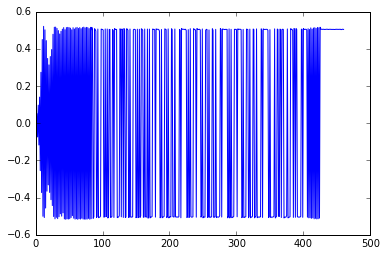

In [19]:
plt.plot( symbols )

Let's check alignment of the symbols after timing recovery. 

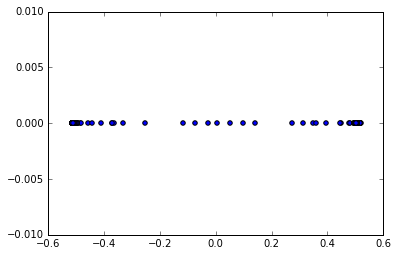

In [20]:
plt.scatter( symbols, np.zeros( len( symbols ) ) )

The dictionary below specifies varicode dictionary which maps bit sequences into ASCI characters.

In [21]:
decode = {
    '1010101011' : '\x00',    '1011011011' : '\x01',
    '1011101101' : '\x02',    '1101110111' : '\x03',
    '1011101011' : '\x04',    '1101011111' : '\x05',
    '1011101111' : '\x06',    '1011111101' : '\x07',
    '1011111111' : '\x08',    '11101111'   : '\x09',
    '11101'      : '\x0A',    '1101101111' : '\x0B',
    '1011011101' : '\x0C',    '11111'      : '\x0D',
    '1101110101' : '\x0E',    '1110101011' : '\x0F',
    '1011110111' : '\x10',    '1011110101' : '\x11',
    '1110101101' : '\x12',    '1110101111' : '\x13',
    '1101011011' : '\x14',    '1101101011' : '\x15',
    '1101101101' : '\x16',    '1101010111' : '\x17',
    '1101111011' : '\x18',    '1101111101' : '\x19',
    '1110110111' : '\x1A',    '1101010101' : '\x1B',
    '1101011101' : '\x1C',    '1110111011' : '\x1D',
    '1011111011' : '\x1E',    '1101111111' : '\x1F',
    '1'          : ' ',       '111111111'  : '!',
    '101011111'  : '"',       '111110101'  : '#',
    '111011011'  : '$',       '1011010101' : '%',
    '1010111011' : '&',       '101111111'  : '\'',
    '11111011'   : '(',       '11110111'   : ')',
    '101101111'  : '*',       '111011111'  : '+',
    '1110101'    : ',',       '110101'     : '-',
    '1010111'    : '.',       '110101111'  : '/',
    '10110111'   : '0',       '10111101'   : '1',
    '11101101'   : '2',       '11111111'   : '3',
    '101110111'  : '4',       '101011011'  : '5',
    '101101011'  : '6',       '110101101'  : '7',
    '110101011'  : '8',       '110110111'  : '9',
    '11110101'   : ':',       '110111101'  : ';',
    '111101101'  : '<',       '1010101'    : '=',
    '111010111'  : '>',       '1010101111' : '?',
    '1010111101' : '@',       '1111101'    : 'A',
    '11101011'   : 'B',       '10101101'   : 'C',
    '10110101'   : 'D',       '1110111'    : 'E',
    '11011011'   : 'F',       '11111101'   : 'G',
    '101010101'  : 'H',       '1111111'    : 'I',
    '111111101'  : 'J',       '101111101'  : 'K',
    '11010111'   : 'L',       '10111011'   : 'M',
    '11011101'   : 'N',       '10101011'   : 'O',
    '11010101'   : 'P',       '111011101'  : 'Q',
    '10101111'   : 'R',       '1101111'    : 'S',
    '1101101'    : 'T',       '101010111'  : 'U',
    '110110101'  : 'V',       '101011101'  : 'W',
    '101110101'  : 'X',       '101111011'  : 'Y',
    '1010101101' : 'Z',       '111110111'  : '[',
    '111101111'  : '\\',      '111111011'  : ']',
    '1010111111' : '^',       '101101101'  : '_',
    '1011011111' : '`',       '1011'       : 'a',
    '1011111'    : 'b',       '101111'     : 'c',
    '101101'     : 'd',       '11'         : 'e',
    '111101'     : 'f',       '1011011'    : 'g',
    '101011'     : 'h',       '1101'       : 'i',
    '111101011'  : 'j',       '10111111'   : 'k',
    '11011'      : 'l',       '111011'     : 'm',
    '1111'       : 'n',       '111'        : 'o',
    '111111'     : 'p',       '110111111'  : 'q',
    '10101'      : 'r',       '10111'      : 's',
    '101'        : 't',       '110111'     : 'u',
    '1111011'    : 'v',       '1101011'    : 'w',
    '11011111'   : 'x',       '1011101'    : 'y',
    '111010101'  : 'z',       '1010110111' : '{',
    '110111011'  : '|',       '1010110101' : '}',
    '1011010111' : '~',       '1110110101' : '\x7F' }

Let's convert symbols into bitstream

In [24]:
z = np.array( symbols )
z2 = np.zeros( z.shape[0], np.bool )
z2[ z > 0 ] = True

BPSK31 defines logical 0 as a phase reversal and logical 1 when there was no phase change. Simple bitwise xor will help with the decoding.  BPSK31 specifcation from ARRL is [here](http://www.arrl.org/psk31-spec)

In [25]:
z3 = np.bitwise_xor( z2[ 1: ], z2[ : -1 ] )
z4 = np.zeros( z3.shape, np.int8 )
z4[ : ] = ord( '1' )
z4[ z3 ] = ord( '0' )

In [26]:
import re
def process_bitstream( s ):
    d = re.split( '00+', s )
    arr = ''
    for d_ in d:
        if d_ in decode:
            arr += decode[ d_ ]
        else:
            arr += '?'
    return arr

Here's the recovered transmission text:

In [27]:
process_bitstream( z4.tostring() )

'?CQ CQ CQ de EA2BAJ EA2BAJ EA2BAJ\rPSE K\r?'

And here is the bitstream

In [28]:
z4.tostring()

'0000000000000000000000000000000000000000000000000000000000000000000000000000000000001010110100111011101001001010110100111011101001001010110100111011101001001011010011001001110111001111101001110110100111010110011111010011111110100100111011100111110100111011010011101011001111101001111111010010011101110011111010011101101001110101100111110100111111101001111100110101010011011110011101110010010111110100111110000000000000000000011111111111111111111111111111111111'